<a href="https://colab.research.google.com/github/chumdan/Machine-Learning-Project/blob/main/Deep%20Learning%20Project/%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%EB%A5%98_RNN_%EC%86%90%EA%B8%80%EC%94%A8_%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 이미지 분류 - RNN(시계열)으로 손글씨 이미지 분류하기

## 데이터  
- MNIST 데이터 손글씨 데이터

## 목표
- 이미지분류의 RNN식 접근
- data augmentation 기법의 이해

## Step 1. 데이터전처리

### 데이터 불러오기 및 기본적 형태 확인

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [ ]:
mnist = keras.datasets.mnist
((train_images, train_labels), (test_images, test_labels)) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(f"train_images:{train_images.shape}")
print(f"train_labels:{train_labels.shape}")
print(f"test_images:{test_images.shape}")
print(f"test_labels:{test_labels.shape}")

train_images:(60000, 28, 28)
train_labels:(60000,)
test_images:(10000, 28, 28)
test_labels:(10000,)


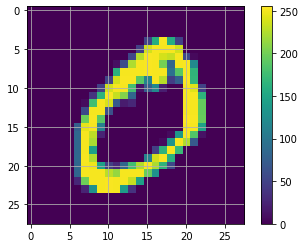

0


In [ ]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(True)
plt.show()
print(train_labels[1])

In [ ]:
print(train_images.dtype)
print(train_labels.dtype)

uint8
uint8


In [ ]:
# train/test 이미지 데이터의 최소/최대값 확인
print(max(train_images.reshape(-1)), min(train_images.reshape(-1)))
print(max(test_images.reshape(-1)), min(test_images.reshape(-1)))

255 0
255 0


### 데이터 노말라이즈 수행

In [ ]:
# train/test 데이터 타입 실수형으로 전환
test_images = test_images.astype(np.float64)
train_images = train_images.astype(np.float64)

In [ ]:
# 최소값이 어차피 0 이기 때문에, 최대값에서 데이터수를 나눠주기만 해도된다.
train_images = train_images / 255
test_images = test_images / 255

In [ ]:
print(list(filter(lambda x:x !=0, train_images[6].reshape(-1)))[:20])

[0.5686274509803921, 1.0, 0.8274509803921568, 0.12156862745098039, 0.12549019607843137, 0.9294117647058824, 0.9921568627450981, 0.9882352941176471, 0.2784313725490196, 0.043137254901960784, 0.6862745098039216, 0.9921568627450981, 0.9882352941176471, 0.2784313725490196, 0.5647058823529412, 0.9921568627450981, 0.9882352941176471, 0.2784313725490196, 0.06274509803921569, 0.7490196078431373]


## Step2. 시각화

In [ ]:
# 여러 이미지 옆으로 붙여서 시각화
# transpose 사용
train_images[:10].transpose((1,0,2)).reshape(28,-1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

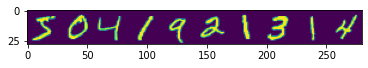

In [ ]:
plt.imshow(train_images[:10].transpose((1,0,2)).reshape(28, -1))
plt.show()

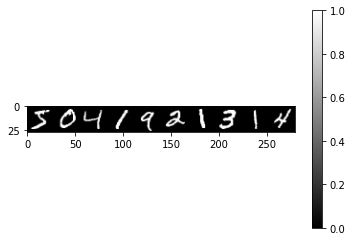

[5 0 4 1 9 2 1 3 1 4]


In [ ]:
# 흑백으로 출력
plt.imshow(train_images[:10].transpose( (1,0,2) ).reshape(28,-1), cmap='gray')
plt.colorbar()
plt.show()
print(train_labels[:10])

### Data augmentation - Noise 를 통한 학습데이터 늘리기

In [ ]:
np.random.random((28,28)).shape

(28, 28)

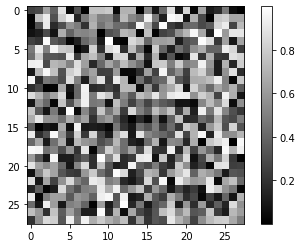

In [ ]:
# 노이즈 확인
plt.imshow(np.random.random((28,28)), cmap="gray")
plt.colorbar()
plt.show()

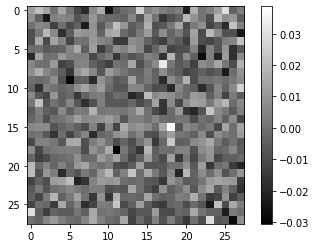

In [ ]:
# np.random.normal 가우시안 노이즈 사용. 
plt.imshow(np.random.normal(0.0, 0.01, (28,28)), cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# train_images와 test_images 데이터에 랜덤 노이즈를 추가
train_noisy_images = train_images + np.random.normal(0.5, 0.1, train_images.shape)
# 노멀라이즈를 했기때문에 1 보다 큰 값은 그냥 그냥 1로 바꿔준다
train_noisy_images[train_noisy_images > 1.0] = 1.0

test_noisy_images = test_images + np.random.normal(0.5 , 0.1, test_images.shape)
test_noisy_images[test_images > 1.0] = 1.0

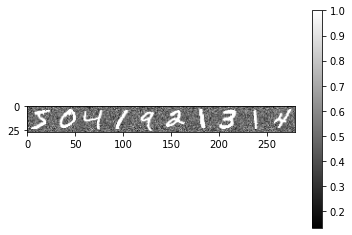

In [ ]:
# 유사한 학습 데이터를 만들었음
plt.imshow(train_noisy_images[:10].transpose( (1,0,2) ).reshape(28,-1), cmap='gray')
plt.colorbar()
plt.show()

### labels에 onehot 인코딩

In [ ]:
from keras.utils import to_categorical
print(train_labels.shape, test_labels.shape)

(60000,) (10000,)


In [ ]:
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)
print(train_labels.shape, test_labels.shape)

(60000, 10) (10000, 10)


## Step 3. 모델링

### RNN 분류 모델

In [ ]:
# fully-conntect를 가진 모델작성
from keras.layers import SimpleRNN
from keras.layers import Dense, Input
from keras.models import Model

inputs = Input(shape=(28,28))
x1 = SimpleRNN(64, activation='tanh')(inputs)
x2 = Dense(10, activation='softmax')(x1)
model = Model(inputs, x2)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                5952      
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 6,602
Trainable params: 6,602
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics =['accuracy'])

### 모델 학습

In [ ]:
hist = model.fit(train_noisy_images, train_labels, validation_data=(test_noisy_images, test_labels), epochs=5, verbose=2 ) 

Epoch 1/5
1875/1875 - 26s - loss: 0.7294 - accuracy: 0.7654 - val_loss: 0.7545 - val_accuracy: 0.7626
Epoch 2/5
1875/1875 - 22s - loss: 0.3852 - accuracy: 0.8846 - val_loss: 0.7308 - val_accuracy: 0.7784
Epoch 3/5
1875/1875 - 21s - loss: 0.3143 - accuracy: 0.9068 - val_loss: 0.5627 - val_accuracy: 0.8226
Epoch 4/5
1875/1875 - 22s - loss: 0.2809 - accuracy: 0.9186 - val_loss: 0.6765 - val_accuracy: 0.7864
Epoch 5/5
1875/1875 - 22s - loss: 0.2596 - accuracy: 0.9253 - val_loss: 0.6955 - val_accuracy: 0.7788


### 학습 진행 사항 plt으로 출력

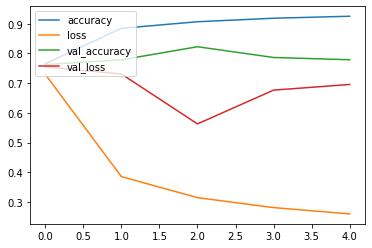

In [ ]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

## Step 4. 결과확인

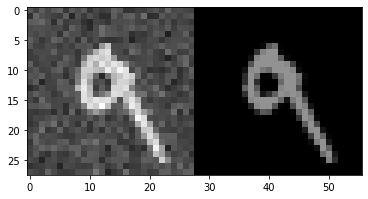

In [ ]:
# np.concatenate  활용 축별 결합
plt.imshow(np.concatenate([test_noisy_images[7], test_images[7]], axis=1), cmap="gray")
plt.show()

###  res와 test_labels[0]의 결과를 plt.bar

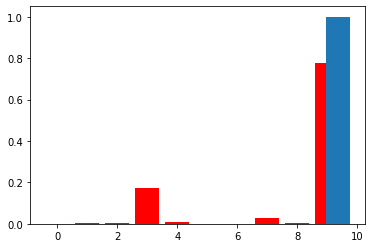

In [ ]:
res = model.predict( test_noisy_images[7:8])
plt.bar(range(10), res[0], color='red')
plt.bar(np.array(range(10)) + 0.35, test_labels[7])
plt.show()

## Step 5. 모델 저장 및 다운로드

In [ ]:
# 모델저장
model.save("./lecture001.h5")

In [ ]:
new_model = tf.keras.models.load_model('./lecture001.h5')

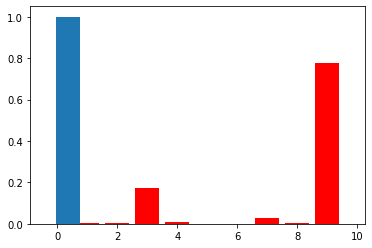

In [ ]:
# 불러온 모델 확인
res = new_model.predict( test_noisy_images[7:8] ) 
res.shape
plt.bar(range(10), res[0], color='red')
plt.bar(np.array(range(10)) + 0.35, test_labels[3])
plt.show()

In [ ]:
loss, acc = new_model.evaluate(test_noisy_images, test_labels, verbose=2)
print(loss, acc)
loss, acc = model.evaluate(test_noisy_images, test_labels, verbose=2)
print(loss, acc)

313/313 - 1s - loss: 0.6955 - accuracy: 0.7788
0.6954827904701233 0.7788000106811523
313/313 - 1s - loss: 0.6955 - accuracy: 0.7788
0.6954827904701233 0.7788000106811523


In [ ]:
# 모델 컴퓨터 저장
from google.colab import files
files.download('./lecture001.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>